In [ ]:
!pip install pyDOE

In [ ]:
import os
import random
import math

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tabulate import tabulate
from pyDOE import lhs
import matplotlib.pyplot as plt

In [ ]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y
        )

        
data = Dataset("/content/drive/MyDrive/Chest_X-ray", test_size=0.2, img_size=128)
print(data.X.shape, data.y.shape)

(618, 128, 128, 3) (618, 2)


In [ ]:
embed = hub.KerasLayer("https://tfhub.dev/google/bit/s-r101x3/ilsvrc2012_classification/1", trainable=False)
X_embedding = embed(data.X)
X_test_embedding = embed(data.X_test)
print(X_embedding.shape, X_test_embedding.shape)

(618, 1000) (155, 1000)


In [ ]:
def make_model(
    nclasses: int, *, dropout_rate: float, nhiddenunits: int, l2_regularization: float
) -> tf.keras.Model:
    model = tf.keras.Sequential()
    # One fully connected hidden layer
    model.add(L.Dense(nhiddenunits, activation="relu", kernel_regularizer=l2(l2_regularization)))
    model.add(L.Dropout(dropout_rate))
    # Output layer
    model.add(L.Dense(nclasses, activation="softmax", kernel_regularizer=l2(l2_regularization)))
    return model

In [ ]:
def evaluate_model(
    nclasses, X, y, X_dev, y_dev, *,
    epochs: int, batch_size: int, learning_rate: float,
    model_maker = make_model, **model_params
) -> tuple:
    
    # Math to compute the learning rate schedule. We will divide our
    # learning rate by a factor of 10 every 30% of the optimizer's
    # total steps.
    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Make and compile the model.
    model = model_maker(nclasses, **model_params)
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the dev set.
    model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=0)
    _, train_acc = model.evaluate(X, y, batch_size=batch_size, verbose=0)
    _, dev_acc = model.evaluate(X_dev, y_dev, batch_size=batch_size, verbose=0)
    return model, train_acc, dev_acc

In [ ]:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params
) -> dict:
    """
    Performs `nfolds` cross-validated training and evaluation of a
    model hyperparameter configuration. Returns a dictionary of
    statistics about the outcome of the cross-validated experiment.
    """
    _, nclasses = y.shape
    train_accs, dev_accs = [], []
    
    # Train and evaluate the model for each fold.
    for train_index, dev_index in tqdm(
        RepeatedStratifiedKFold(
            n_splits=nfolds, n_repeats=nrepeats, random_state=seed
        ).split(X, labels),
        total=nfolds*nrepeats, disable=not verbose
    ):
        
        # Select the data for this fold.
        X_train_fold = tf.gather(X, train_index) 
        y_train_fold = tf.gather(y, train_index)
        X_dev_fold = tf.gather(X, dev_index)
        y_dev_fold = tf.gather(y, dev_index)
        
        # Train and evaluate the model.
        _, train_acc, dev_acc = evaluate_model(
            nclasses,
            X_train_fold,
            y_train_fold,
            X_dev_fold,
            y_dev_fold,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            model_maker=model_maker,
            **model_params
        )
        train_accs.append(train_acc)
        dev_accs.append(dev_acc)
    
    # Aggregate.
    results = {
        "train_mean": np.mean(train_accs),
        "train_std": np.std(train_accs),
        "dev_mean": np.mean(dev_accs),
        "dev_std": np.std(dev_accs)
    }
    
    # Report.
    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Dev", results["dev_mean"], results["dev_std"]]
                ],
                headers=["Set", "Mean", "Std. Dev."]
            )
        )
    
    return results

In [ ]:
# We'll refer to these values throughout the notebook.
default_cv_evaluate_params = {
    "X": X_embedding,
    "y": data.y,
    "labels": data.labels,
    "nfolds": 10,
    "nrepeats": 3,
    "model_maker": make_model,
    "epochs": 200,
    "batch_size": 32,
    "verbose": False,
    "learning_rate": 3e-3,
    "dropout_rate": 0.3,
    "nhiddenunits": 64,
    "l2_regularization": 1e-6
}

_ = cv_evaluate_model(
    **{
        **default_cv_evaluate_params,
        "verbose": True
    }
)

100%|██████████| 30/30 [03:36<00:00,  7.21s/it]

Set        Mean    Std. Dev.
-----  --------  -----------
Train  0.984295    0.0170633
Dev    0.697999    0.0546028


In [ ]:
nsamples = 5
# `lhs` will yield a `nsamples`x2 matrix, with all values following
# the uniform distribution in [0,1]
np.random.seed()
x = lhs(n=2, samples=nsamples)
# Scale dropout samples to be in [0,0.6]
dropout_rates = (x[:, 0]*.6)
# Scale l2 samples to be in [-8, -1]
l2_rates = (x[:, 1]*-7 - 1)
# Now scale l2 samples to follow the
# log scale in the range [10**-8,10**-1]
l2_rates = 10**l2_rates

In [ ]:
dev_means = np.zeros((nsamples, 1))
dev_stds = np.zeros((nsamples, 1))
for i in tqdm(range(nsamples)):
    results = cv_evaluate_model(
        **{
            **default_cv_evaluate_params,
            "dropout_rate": dropout_rates[i],
            "l2_regularization": l2_rates[i]
        }
    )
    dev_means[i] = results["dev_mean"]
    dev_stds[i] = results["dev_std"]

100%|██████████| 5/5 [17:56<00:00, 215.29s/it]


Best l2_rate:	0.00038634382296084
Best dropout:	0.12804643378265318


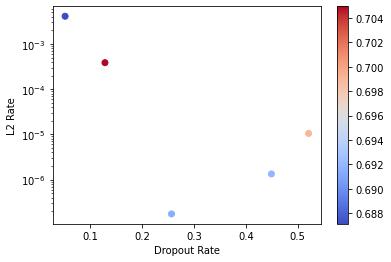

In [ ]:
best_i = np.argmax(dev_means)
best_l2 = l2_rates[best_i]
print(f"Best l2_rate:\t{best_l2}")
best_dropout = dropout_rates[best_i]
print(f"Best dropout:\t{best_dropout}")

plt.scatter(dropout_rates, l2_rates, c=dev_means, cmap=plt.cm.coolwarm)
plt.xlabel("Dropout Rate")
plt.ylabel("L2 Rate")
plt.yscale("log")
plt.colorbar()
plt.show()

In [ ]:
default_cv_evaluate_params["dropout_rate"] = best_dropout
default_cv_evaluate_params["l2_regularization"] = best_l2

In [ ]:
def search_hyperparam(
    param_name: str, lower: int, upper: int, nsamples: int,
    scale: str = "float", **cv_evaluate_params
) -> float:
    """
    Cross validates a model along an evenly spaced range of `nsamples`
    values for a single hyperparameter (identified by `param_name`. The
    values are evenly spaced in the range `[lower,upper]`, and scaled
    according to `scale`.
    """
    # Sample the hyperparameter values to try.
    param_values = np.linspace(lower, upper, nsamples)
    if scale == "log":
        param_values = 10**param_values
    elif scale == "int":
        param_values = param_values.astype(int)
    
    # Evaluate the model at each of the values.
    dev_means = np.zeros((nsamples, 1))
    dev_stds = np.zeros((nsamples, 1))
    for i in tqdm(range(nsamples)):
        results = cv_evaluate_model(
            **{
                **cv_evaluate_params,
                param_name: param_values[i]
            }
        )
        dev_means[i] = results["dev_mean"]
        dev_stds[i] = results["dev_std"]
    
    # Find the best value.
    best_param_value = param_values[np.argmax(dev_means)]
    print(f"Best {param_name} value: {best_param_value}")
    
    # Plot scores achieved for all values.
    plt.plot(param_values, dev_means)
    plt.xlabel(param_name)
    plt.ylabel("Mean Dev Set Accuracy")
    if scale == "log":
        plt.xscale("log")
    plt.show()
    
    return best_param_value

100%|██████████| 5/5 [22:58<00:00, 275.72s/it]

Best epochs value: 20


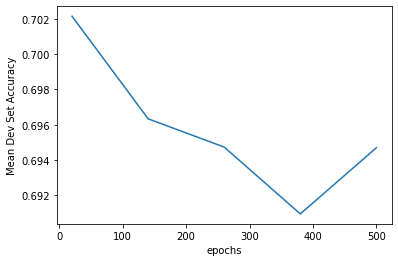

In [ ]:
best_epochs = search_hyperparam("epochs", 20, 500, 5, scale="int", **default_cv_evaluate_params)

In [ ]:
#best_epochs2 = search_hyperparam("epochs", 400, 800, 5, scale="int", **default_cv_evaluate_params)

In [ ]:
default_cv_evaluate_params["epochs"] = best_epochs

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Epoch 1/20
18/18 [==============================] - 1s 11ms/step - loss: 0.9103 - accuracy: 0.6097 - val_loss: 0.7290 - val_accuracy: 0.5806
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6835 - val_loss: 0.7467 - val_accuracy: 0.5806
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.7158 - val_loss: 0.6789 - val_accuracy: 0.6935
Epoch 4/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5996 - accuracy: 0.7302 - val_loss: 0.6717 - val_accuracy: 0.7097
Epoch 5/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5580 - accuracy: 0.7446 - val_loss: 0.6148 - val_accuracy: 0.7742
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5422 - accuracy: 0.7626 - val_loss: 0.6149 - val_accuracy: 0.6935
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5036 - accuracy: 0.7680 - val_loss: 0.6139 - val_accuracy: 0.6613
Epoch 8/20
18/18 [=

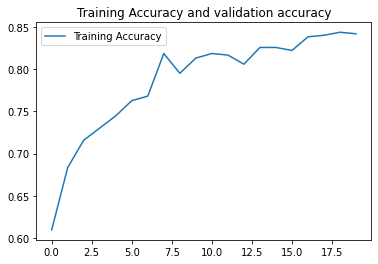

In [ ]:
def evaluate_final(params: dict) -> float:
    
    steps_per_epoch = math.ceil(len(X_embedding) / params["batch_size"])
    third_of_total_steps = math.floor(params["epochs"] * steps_per_epoch / 3)

    # Make and compile the model.
    model = make_model(
        data.nclasses,
        dropout_rate=params["dropout_rate"],
        nhiddenunits=params["nhiddenunits"],
        l2_regularization=params["l2_regularization"]
    )
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                params["learning_rate"],
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Train the model on the full training set (no development set)
    history = model.fit(
        X_embedding,
        tf.convert_to_tensor(data.y),
        batch_size=params["batch_size"],
        validation_split = 0.1,
        epochs=params["epochs"],
        verbose=1
    )

    # Evaluate the fitted model on the test set.
    _, test_acc = model.evaluate(
        X_test_embedding,
        data.y_test,
        verbose=0
    )
    # Plotting training and validation accuracy per epoch

    train_acc = history.history["accuracy"]
    

    epochs = range(len(train_acc)) 

    plt.plot(epochs, train_acc)
    
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.title("Training Accuracy and validation accuracy")
    return test_acc

test_acc = evaluate_final(default_cv_evaluate_params)
print(f"Final test set accuracy:\t{test_acc:.6f}")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/20
18/18 [==============================] - 1s 9ms/step - loss: 0.9186 - accuracy: 0.6061 - val_loss: 0.6917 - val_accuracy: 0.6774
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.7014 - val_loss: 0.6523 - val_accuracy: 0.6774
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.7302 - val_loss: 0.6135 - val_accuracy: 0.7258
Epoch 4/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5873 - accuracy: 0.7464 - val_loss: 0.6338 - val_accuracy: 0.7258
Epoch 5/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5573 - accuracy: 0.7752 - val_loss: 0.6288 - val_accuracy: 0.6613
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5249 - accuracy: 0.7698 - val_loss: 0.6147 - val_accuracy: 0.6613
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5331 - accuracy: 0.7698 - val_loss: 0.5821 - val_accuracy: 0.7419
Epoch 8/20
18/18 [==

 50%|█████     | 1/2 [00:03<00:03,  3.01s/it]

Epoch 1/20
18/18 [==============================] - 1s 9ms/step - loss: 0.8404 - accuracy: 0.5899 - val_loss: 0.6977 - val_accuracy: 0.7258
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.7158 - val_loss: 0.6364 - val_accuracy: 0.7742
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.7194 - val_loss: 0.7543 - val_accuracy: 0.6129
Epoch 4/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5737 - accuracy: 0.7464 - val_loss: 0.6437 - val_accuracy: 0.7258
Epoch 5/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5585 - accuracy: 0.7446 - val_loss: 0.6677 - val_accuracy: 0.6774
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5375 - accuracy: 0.7590 - val_loss: 0.6425 - val_accuracy: 0.7581
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.7806 - val_loss: 0.6365 - val_accuracy: 0.6613
Epoch 8/20
18/18 [==

100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


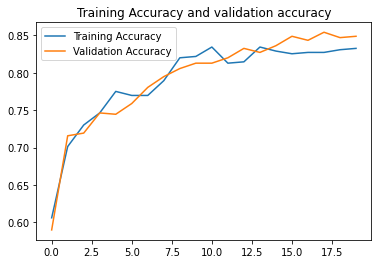

In [ ]:
test_accs = []
for _ in tqdm(range(2)):
    test_accs.append(evaluate_final(default_cv_evaluate_params))

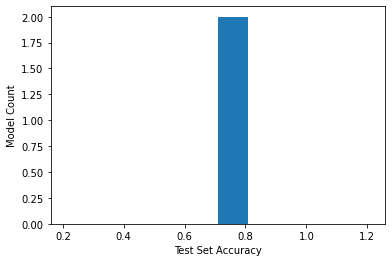

In [ ]:
plt.hist(test_accs)
plt.xlabel("Test Set Accuracy")
plt.ylabel("Model Count")
plt.show()